In [1]:
from depsurf import get_symbol_info, DBGSYM_PATH

df = get_symbol_info(DBGSYM_PATH / "6.5.0-27-generic")

In [5]:
func_df = df[df.type == "STT_FUNC"]
local_func_df = func_df[func_df["bind"] == "STB_LOCAL"]
len(local_func_df)

73696

In [44]:
renamed_df = func_df[func_df.name.str.contains(r"\.")]

assert (renamed_df.name.isin(local_func_df.name)).all()

print(len(renamed_df))

renamed_df

10604


,name,section,bind,type,visibility,value,size
120,native_write_idt_entry.constprop.0,.text,STB_LOCAL,STT_FUNC,STV_DEFAULT,ffffffff8104a060,32
121,set_bringup_idt_handler.constprop.0,.text,STB_LOCAL,STT_FUNC,STV_DEFAULT,ffffffff8104a090,130
122,sanitize_boot_params.constprop.0,.text,STB_LOCAL,STT_FUNC,STV_DEFAULT,ffffffff8104a130,657
130,__pfx_native_write_idt_entry.constprop.0,.text,STB_LOCAL,STT_FUNC,STV_DEFAULT,ffffffff8104a050,16
131,__pfx_set_bringup_idt_handler.constprop.0,.text,STB_LOCAL,STT_FUNC,STV_DEFAULT,ffffffff8104a080,16
...,...,...,...,...,...,...,...
119947,get_regno.isra.0.cold,.text,STB_LOCAL,STT_FUNC,STV_DEFAULT,ffffffff821197f5,20
119957,insn_get_modrm_rm_off.cold,.text,STB_LOCAL,STT_FUNC,STV_DEFAULT,ffffffff82119809,20
119958,insn_get_modrm_reg_off.cold,.text,STB_LOCAL,STT_FUNC,STV_DEFAULT,ffffffff8211981d,20
119959,insn_get_modrm_reg_ptr.cold,.text,STB_LOCAL,STT_FUNC,STV_DEFAULT,ffffffff82119831,20


In [46]:
suffix_df = renamed_df.name.map(
    lambda x: x.split(".", 1)[-1].replace(".0", "")
).value_counts()

suffix_df = suffix_df.reset_index()
suffix_df.columns = ["suffix", "count"]
suffix_df["renamed %"] = suffix_df["count"] / len(renamed_df) * 100
suffix_df["local %"] = suffix_df["count"] / len(local_func_df) * 100


print(suffix_df["local %"].sum())

suffix_df

14.388840642640035


,suffix,count,renamed %,local %
0,cold,5986,56.450396,8.122558
1,constprop,1886,17.785741,2.559162
2,isra,1182,11.146737,1.603886
3,part,1008,9.505847,1.367781
4,constprop.cold,189,1.782346,0.256459
5,constprop.isra,114,1.075066,0.154690
6,isra.cold,106,0.999623,0.143834
7,part.cold,78,0.735571,0.105840
8,part.isra,28,0.264051,0.037994
9,part.constprop,12,0.113165,0.016283


In [47]:
import pandas as pd

combined = suffix_df["suffix"].str.contains(r"\.")

plot_df = pd.concat(
    [
        suffix_df[~combined],
        pd.DataFrame(
            {
                "suffix": "≥2",
                **suffix_df[combined].sum(numeric_only=True),
            },
            index=[0]
        )
    ],
    ignore_index=True
)

plot_df

,suffix,count,renamed %,local %
0,cold,5986.0,56.450396,8.122558
1,constprop,1886.0,17.785741,2.559162
2,isra,1182.0,11.146737,1.603886
3,part,1008.0,9.505847,1.367781
4,≥2,542.0,5.111279,0.735454


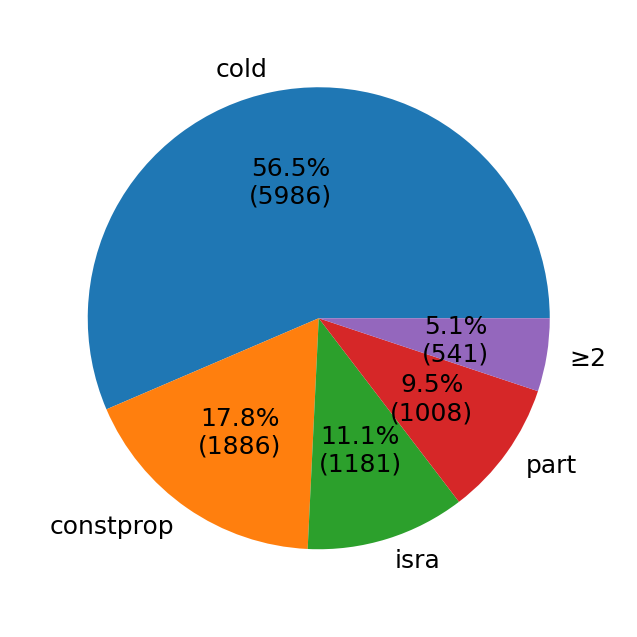

In [48]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(2.5, 2.5), dpi=300)


total = plot_df["count"].sum()

ax.pie(
    plot_df["count"],
    labels=plot_df["suffix"],
    autopct=lambda pct: f"{pct:.1f}%\n({int(pct * total / 100)})",
    textprops={'fontsize': 6}
)

plt.show()